In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import random
import seaborn as sns
%pylab inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
from sklearn.externals import joblib
from nltk.corpus import stopwords
from collections import defaultdict

Populating the interactive namespace from numpy and matplotlib


/home/dgilberg/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Table of Contents
* [Modeling](#modeling)
* [All Committees](#all_committees)
* [Evaluation](#eval)
* [Foreign Relations](#foreign_relations)
* [Testing](#testing)

In [5]:
for dl in ["averaged_perceptron_tagger", "maxent_treebank_pos_tagger", "punkt", "maxent_ne_chunker", "words"]:
    nltk.download(dl)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/dgilberg/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /home/dgilberg/nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/dgilberg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/dgilberg/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/dgilberg/nltk_data...
[nltk_data]   Package words is already up-to-date!


## Modeling <a class="anchor" id="modeling"></a>

In [2]:
all_df = pd.read_pickle("/home/dgilberg/nlp_partisanship/data/all_committees.pkl")
all_df


,Committee,Date,Day,Label,Month,Party,Release,Title,Year
0,Agriculture,2017-11-09,9,"Democratic, Agriculture",11,Democratic,WASHINGTON – U.S. Senator Debbie Stabenow (D-...,Ranking Member Stabenow Opening Statement at H...,2017
1,Agriculture,2017-11-02,2,"Democratic, Agriculture",11,Democratic,"WASHINGTON - Today, U.S. Senator Debbie Stabe...",Statement from Ranking Member Stabenow on the ...,2017
2,Agriculture,2017-11-01,1,"Democratic, Agriculture",11,Democratic,"WASHINGTON – Today, U.S. Senator Debbie Stabe...",Ranking Member Stabenow Asks Clovis about his ...,2017
3,Agriculture,2017-10-18,18,"Democratic, Agriculture",10,Democratic,"WASHINGTON, D.C. – Today, U.S. Senator Debbie...",Stabenow Offers Budget Amendment to Protect th...,2017
4,Agriculture,2017-10-17,17,"Democratic, Agriculture",10,Democratic,Improvements to the successful Regional Conse...,"Stabenow, Ernst Introduce Bipartisan Bill to S...",2017
5,Agriculture,2017-10-05,5,"Democratic, Agriculture",10,Democratic,WASHINGTON – U.S. Senator Debbie Stabenow (D-...,Ranking Member Stabenow Opening Statement at H...,2017
6,Agriculture,2017-09-28,28,"Democratic, Agriculture",9,Democratic,"WASHINGTON – U.S. Senator Debbie Stabenow, Ra...",Ranking Member Stabenow Highlights Economic Im...,2017
7,Agriculture,2017-09-19,19,"Democratic, Agriculture",9,Democratic,WASHINGTON – U.S. Senator Debbie Stabenow (D-...,Ranking Member Stabenow Opening Statement at H...,2017
8,Agriculture,2017-09-14,14,"Democratic, Agriculture",9,Democratic,"WASHINGTON – U.S. Senator Debbie Stabenow, Ra...",Ranking Member Stabenow Opening Statement at H...,2017
9,Agriculture,2017-08-31,31,"Democratic, Agriculture",8,Democratic,"WASHINGTON – Today, U.S. Senator Debbie Stabe...",Ranking Member Stabenow Applauds New MPP Flexi...,2017


In [3]:
my_stops = stopwords.words()
leg_df = pd.read_csv("data/legislators-current.csv")
last_names = [name.lower() for name in list(leg_df.last_name)]
my_stops += last_names
excess_words = ["statement", "congress", "senator", "senate", "congressman", "committee", "whether", "role","since",
               "united", "states", "well", "much", "department", "congress", "like", "senators", "two", "three",
               "mr", "ms", "chairman", "ranking", "member"]
my_stops += excess_words
all_releases = list(all_df["Release"])
corpus = list()
for index, release in enumerate(all_releases):
    sents = nltk.sent_tokenize(release)
    corpus += sents

In [10]:
tfidf = TfidfVectorizer(max_df=0.99, min_df=0.01, stop_words=my_stops, 
                        token_pattern="\\b[a-z][a-z]+\\b", ngram_range=(1,2))

rel_tf = tfidf.fit_transform(corpus)
# nmf = NMF(n_components=100, init="random", random_state=42)

# rel_nmf = nmf.fit_transform(rel_tf)

In [3]:
nmf = joblib.load("/home/dgilberg/nlp_partisanship/data/100_topics.pkl")
tfidf = joblib.load("/home/dgilberg/nlp_partisanship/data/tfidf.pkl")

In [7]:
for topic_idx, topic in enumerate(nmf.components_):
    print ("Topic #%d:" % topic_idx)
    print (" ".join([tfidf.get_feature_names()[i]
                    for i in topic.argsort()[:-10 - 1:-1]]))

Topic #0:
health insurance services labor costs human women quality cost access
Topic #1:
act water passed protection reform review education quality part opportunity
Topic #2:
million level request increase provides fiscal additional assistance funds research
Topic #3:
program nuclear assistance insurance funds development benefits provides improve based
Topic #4:
way change believe better together hope going address without spending
Topic #5:
children women access protect quality high better services ensure future
Topic #6:
must ensure order clear believe address protect better future agreement
Topic #7:
said needs critical going clear better without communities put relations
Topic #8:
federal agencies funds private local spending debt service insurance transportation
Topic #9:
many colleagues issues communities high believe market companies students service
Topic #10:
public environment works commerce private transportation service republican protect following
Topic #11:
law current

In [14]:
no_topics = str(nmf.n_components)
file_path = "{}_topics.pkl".format(no_topics)
#joblib.dump(clf, 'filename.pkl') 
joblib.dump(nmf, file_path)
tf_file = "home/dgilberg/nlp_partisanship/data"
joblib.dump(tfidf, "tfidf.pkl")

['tfidf.pkl']

## Evaluation Methods <a class="anchor" id="eval"></a>

In [6]:
def get_rel_score(release):
    #print(len(release))
    try:
        sents = nltk.sent_tokenize(release)
    except:
        sents = list()
        
    if len(sents) > 0:
        sents_tf = tfidf.transform(sents)
        
        sents_nmf = nmf.transform(sents_tf)
       
        score = sents_nmf.mean(axis=0)
    else:
        score = [0]
    return list(score)

def get_rel_average(arr):
    final = list()
    for index, rel in enumerate(arr):
        #print(index)
        final.append(get_rel_score(rel))
    final = pd.DataFrame(final)
    return np.array(final.mean(axis=0))

def get_all_rel_scores(arr):
    final = list()
    for rel in arr:
        
        final.append(get_rel_score(rel))
    
    return final

def get_coords(matrix2D):
    x = []
    y = []
    for r in matrix2D:
        x.append(r[0])
        y.append(r[1])
    return x, y

def get_party_classification(party):
    if party == "Democratic":
        return 0
    else:
        return 1

def compare_parties(df):
    dem_df = df[df.Party == "Democratic"]
    rep_df = df[df.Party == "Republican"]
    dem_rel = get_rel_average(list(dem_df.Release))
    rep_rel = get_rel_average(list(rep_df.Release))
    dist = pairwise_distances(dem_rel.reshape(1,-1), rep_rel.reshape(1,-1), metric="cosine")
    return dist

def get_committee_average(df, committee):
    df = df[df.Committee == committee]
    rels = list(df.Release)
    return get_rel_average(rels)
    

def get_party_committee_score(df, party, committee):
    mask = (df.Committee == committee) & (df.Party == party)
    df = df[mask]
    rels = list(df.Release)
    return get_rel_average(rels)

## All Committees <a class="anchor" id="all_committees"></a>

In [97]:
all_releases = list(all_df.Release)

In [98]:
all_scores = get_all_rel_scores(all_releases)

In [101]:
all_scores_df = pd.DataFrame(all_scores)
all_scores = all_scores_df.fillna(0)

In [17]:
all_tsne = TSNE(n_components=2)

In [36]:
test = all_df.Committee.unique()

In [99]:
colors = list()
for i in range(len(test)):
    colors.append("#%06x" % random.randint(0, 0xFFFFFF))
    
colors = ["#BF7F3F", "#EECF13", "#054713", "#09EEF4", "#0930F4", "#060309", "#7B19DD", "#43FF7F", "#E51EB5"]

colors_dict = dict(zip(test, colors))

colors_dict

all_df["color"] = all_df.apply(lambda row: colors_dict[row["Committee"]], axis=1)

In [77]:
colors_dict

{'Agriculture': '#BF7F3F',
 'Appropriations': '#EECF13',
 'Banking': '#054713',
 'Budget': '#09EEF4',
 'Commerce': '#0930F4',
 'Finance': '#060309',
 'Foreign Relations': '#7B19DD',
 'HELP': '#43FF7F',
 'Small Business': '#E51EB5'}

Agriculture: Beige/Brown

Appr: Yellow

Banking: Dark Green

Budget: Teal

Commerce: Blue

Finance: Black

Foreign Relations: Purple

HELP: light green

SB: Pink

In [102]:
all_results = all_tsne.fit_transform(all_scores)

all_x, all_y = get_coords(all_results)

/home/dgilberg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


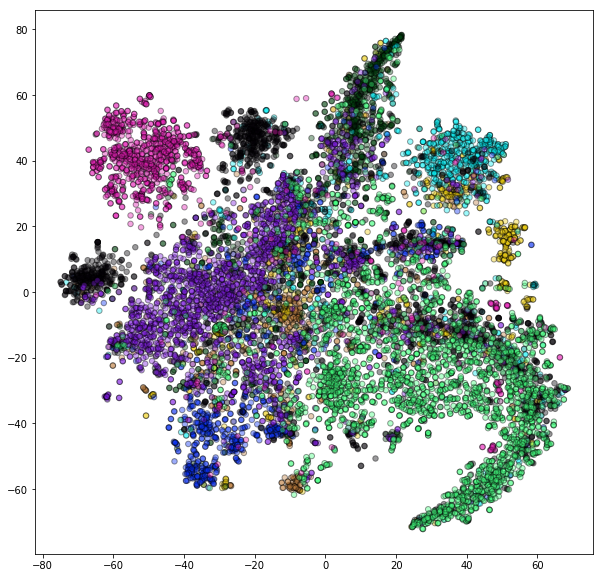

In [103]:
plt.figure(figsize=(10,10))


plt.scatter(all_x, all_y, alpha=0.4, c=all_df["color"], cmap=colors_arr, marker='o', s=30, edgecolor="black");
plt.legend()

In [136]:
#compare_parties(all_df)
dem = all_df[all_df.Party == "Democratic"]
dem_releases = list(dem["Release"])


In [293]:
compare_parties(all_df)

array([[ 0.02839791]])

list

In [132]:
x[0:1]

[' WASHINGTON – U.S. Senator Debbie Stabenow (D-Mich.), Ranking Member of the U.S. Senate Committee on Agriculture, Nutrition, & Forestry, today released the following opening statement – as prepared for delivery – at the nomination hearing to consider Glen Smith to be a Member of the Farm Credit Administration Board, and Stephen Vaden to be General Counsel of the U.S. Department of Agriculture (USDA). Stabenow’s statement, as prepared for delivery, follows: I am pleased to be here to consider the final two nominees pending before our committee. Mr. Vaden and Mr. Smith, congratulations to both of you, and welcome to your families here today. Considering presidential nominations is a key responsibility of the Senate – and one that this Committee takes very seriously. This Committee has worked hard to move nine USDA and CFTC nominees this year in an efficient and bipartisan manner. I am glad to see two more nominees before us today.  Mr. Vaden, being the top lawyer at one of the largest 

## Foreign Relations <a class="anchor" id="foreign_relations"></a>

In [20]:
fr_df = all_df[all_df.Committee == "Foreign Relations"]
dem_fr = fr_df[fr_df.Party == "Democratic"]
rep_fr = fr_df[fr_df.Party == "Republican"]

In [27]:
pd.DataFrame(fr_df.groupby(["Party", "Committee"], as_index=False)["Release"].agg(lambda col: " ".join(col))).iloc[1]

Party                                               Republican
Committee                                    Foreign Relations
Release       WASHINGTON – The Senate Foreign Relations Com...
Name: 1, dtype: object

In [316]:
compare_parties(fr_df)

array([[ 0.09375304]])

In [105]:
dem_fr_scores = get_rel_average(list(dem_fr["Release"]))
rep_fr_scores = get_rel_average(list(rep_fr["Release"]))

In [133]:
y = get_rel_average(list(dem_fr["Release"]))
y[0]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

array([  1.09346993e-02,   5.26360332e-03,   1.27315705e-01,
         2.06491445e-01,   8.30959844e-02,   2.46052845e-03,
         3.13979545e-02,   4.57482878e-02,   7.41226160e-02,
         1.07195811e-03,   1.44235352e-04,   9.16711020e-02,
         2.32193683e-04,   1.38666774e-01,   6.53252612e-03,
         2.19528598e-03,   1.43400016e-01,   4.09242313e-04,
         5.19328480e-03,   4.92285999e-03,   1.56044762e-04,
         3.69403359e-02,   9.16659559e-02,   2.50074596e-02,
         5.99331634e-03,   1.15385495e-03,   7.58869121e-02,
         3.30475476e-04,   4.92355013e-02,   6.48502758e-03,
         6.83779772e-04,   3.83265664e-04,   2.54907781e-02,
         1.70093196e-03,   1.48737772e-04,   0.00000000e+00,
         2.66702408e-04,   8.31991127e-05,   8.21720062e-02,
         2.26454196e-04,   1.60962591e-03,   0.00000000e+00,
         3.55568839e-04,   9.13094001e-04,   0.00000000e+00,
         0.00000000e+00,   1.20965325e-01,   7.54888189e-04,
         1.82585069e-03,

In [126]:
dem_fr_scores

array([ 0.04867546,  0.04075747,  0.07759608,  0.04233207,  0.02044419,
        0.02867035,  0.03531035,  0.04981336,  0.04922244,  0.03017634,
        0.03124632,  0.04280059,  0.03157356,  0.02275051,  0.00748383,
        0.04871278,  0.0290744 ,  0.00169432,  0.00527825,  0.00669659,
        0.01069791,  0.04711194,  0.01879179,  0.01429104,  0.00772005,
        0.00903421,  0.02433852,  0.00868107,  0.01995996,  0.00927079,
        0.01684374,  0.02948088,  0.00963734,  0.00703449,  0.00986784,
        0.00695043,  0.01013229,  0.00343228,  0.01760416,  0.01781617,
        0.00671641,  0.01388131,  0.00558879,  0.02075885,  0.01277524,
        0.01202878,  0.02218773,  0.00838659,  0.00768615,  0.0096409 ,
        0.00831516,  0.00447308,  0.00529753,  0.00513658,  0.01236587,
        0.02072264,  0.00634943,  0.09318915,  0.04076915,  0.00804265,
        0.00778574,  0.01465412,  0.0024848 ,  0.00847498,  0.00276713,
        0.02045156,  0.0312231 ,  0.00504633,  0.01655615,  0.00

In [107]:
pairwise_distances(dem_fr_scores.reshape(1,-1), rep_fr_scores.reshape(1,-1), metric="cosine")

array([[ 0.09375304]])

In [180]:
compare_parties(fr_df)

array([[ 0.09375304]])

In [88]:
dem_fr_scores.argsort()[-5:]

array([ 2,  1, 57,  4,  0])

In [87]:
rep_fr_scores.argsort()[-5:]

array([74,  1, 57,  4,  0])

/home/dgilberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/dgilberg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


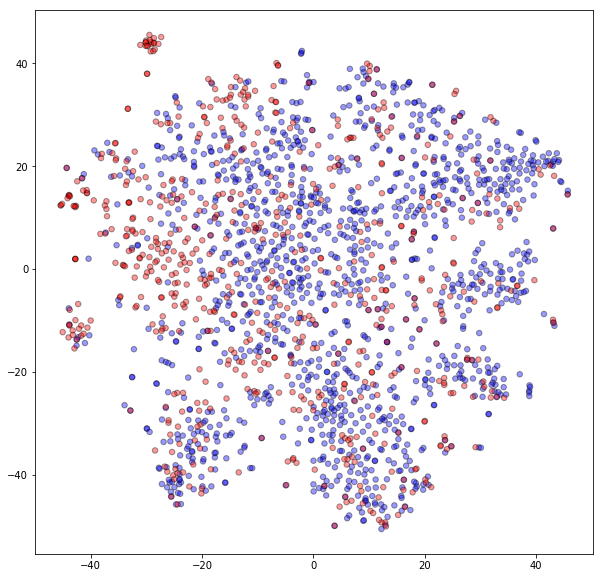

In [96]:
fr_tsne = TSNE(n_components=2)

fr_scores = get_all_rel_scores(list(fr_df.Release))

fr_scores = pd.DataFrame(fr_scores)

fr_results = fr_tsne.fit_transform(fr_scores)

fr_df["Party_Classification"] = fr_df.apply(lambda row: get_party_classification(row["Party"]), axis=1)
fr_x, fr_y = get_coords(fr_results)

plt.figure(figsize=(10,10))
colors = np.array(["blue", "red"])
plt.scatter(fr_x, fr_y, alpha=0.4, c=colors[fr_df["Party_Classification"]], marker='o', s=30, cmap='tab10', edgecolor="black");
plt.legend()

## Commerce <a class="anchor" id="commerce"></a>

In [142]:
comm_df = all_df[all_df.Committee == "Commerce"]
dem_comm = comm_df[comm_df.Party == "Democratic"]
rep_comm = comm_df[comm_df.Party == "Republican"]

In [314]:
compare_parties(comm_df)

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [98]:
dem_comm_scores = get_rel_average(list(dem_comm["Release"]))
rep_comm_scores = get_rel_average(list(rep_comm["Release"]))

In [99]:
pairwise_distances(dem_comm_scores.reshape(1,-1), rep_comm_scores.reshape(1,-1), metric="cosine")

array([[ 0.08519327]])

In [52]:
rep_comm_scores.argmax()

25

In [56]:
rep_comm_scores.argsort()[-5:]

array([ 4,  6, 52, 12, 25])

In [57]:
dem_comm_scores.argsort()[-5:]

array([56,  2,  0,  4, 25])

/home/dgilberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/dgilberg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


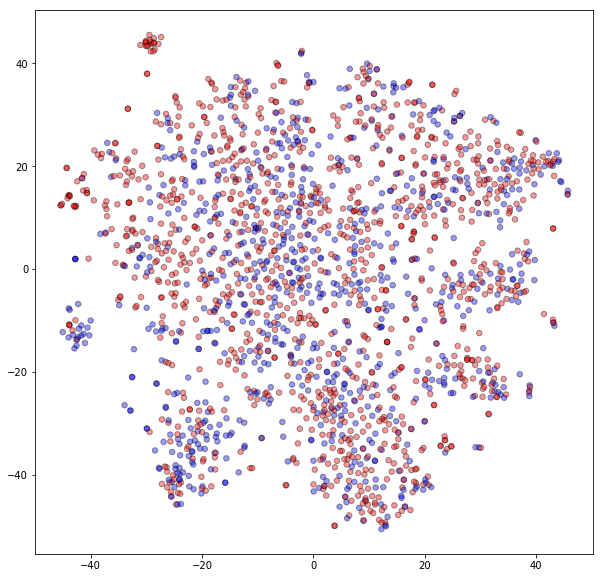

In [100]:
comm_tsne = TSNE(n_components=2)

comm_scores = get_all_rel_scores(list(comm_df.Release))

comm_scores = pd.DataFrame(comm_scores)

comm_results = comm_tsne.fit_transform(comm_scores)

comm_df["Party_Classification"] = comm_df.apply(lambda row: get_party_classification(row["Party"]), axis=1)
comm_x, comm_y = get_coords(comm_results)

plt.figure(figsize=(10,10))
colors = np.array(["blue", "red"])
plt.scatter(fr_x, fr_y, alpha=0.4, c=colors[comm_df["Party_Classification"]], marker='o', s=30, cmap='tab10', edgecolor="black");
plt.legend()

In [147]:
compare_parties(comm_df)

array([[ 0.10787293]])

## Agriculture <a class="anchor" id="agriculture"></a>

In [148]:
ag_df = all_df[all_df.Committee == "Agriculture"]

In [312]:
df = get_rel_average(list(ag_df.Release))
cols  = list()
for i in range(1,101):
    test = str(i)
    cols.append("ag" + test)
    
df.columns = cols
df.mean()

,ag1,ag2,ag3,ag4,ag5,ag6,ag7,ag8,ag9,ag10,...,ag91,ag92,ag93,ag94,ag95,ag96,ag97,ag98,ag99,ag100
0,0.001501,0.004759,0.009963,0.008844,0.005342,0.013944,0.000796,0.002143,0.001736,0.132895,...,0.069701,0.001129,0.031678,0.000000,0.015384,0.001876,0.000985,0.012422,0.001212,8.841753e-03
1,0.012812,0.009335,0.048585,0.004897,0.012433,0.000718,0.003428,0.005445,0.002732,0.001821,...,0.000000,0.004143,0.002894,0.000000,0.001546,0.001809,0.011319,0.000099,0.000332,1.161324e-03
2,0.001969,0.001501,0.000000,0.006681,0.295192,0.000034,0.001204,0.000379,0.000291,0.023369,...,0.000076,0.000312,0.092941,0.000301,0.000005,0.000503,0.002326,0.000554,0.000263,1.219769e-05
3,0.268470,0.005047,0.212695,0.005865,0.003369,0.013322,0.000121,0.004149,0.177226,0.000825,...,0.043363,0.000133,0.002411,0.018940,0.028609,0.002422,0.000000,0.000000,0.000396,2.234944e-04
4,0.086162,0.000249,0.079950,0.004725,0.111321,0.008348,0.112347,0.118159,0.060282,0.040255,...,0.035722,0.000701,0.049910,0.007791,0.001845,0.001150,0.000555,0.001728,0.022945,1.427930e-03
5,0.138292,0.013974,0.002172,0.003014,0.003315,0.041916,0.000739,0.023750,0.001362,0.002700,...,0.027333,0.000331,0.012010,0.020455,0.024810,0.075840,0.001070,0.000154,0.027177,2.948716e-04
6,0.004046,0.005242,0.001400,0.005671,0.002344,0.103598,0.000925,0.088450,0.034863,0.046600,...,0.007893,0.000548,0.024813,0.008977,0.073243,0.019704,0.000516,0.000058,0.051998,8.974282e-05
7,0.000533,0.001499,0.001603,0.115057,0.006601,0.006135,0.000644,0.030524,0.001671,0.003809,...,0.087854,0.000444,0.013479,0.000118,0.045896,0.027472,0.000514,0.000245,0.009888,1.820239e-04
8,0.100660,0.015330,0.002071,0.005380,0.005594,0.189193,0.000375,0.059159,0.002043,0.001649,...,0.168810,0.000893,0.037863,0.000766,0.049438,0.001229,0.001763,0.002336,0.005619,9.482143e-04
9,0.039630,0.000000,0.000000,0.003224,0.031589,0.007191,0.000000,0.000000,0.000238,0.000000,...,0.000000,0.000928,0.170504,0.000000,0.000000,0.001710,0.005328,0.000000,0.008367,0.000000e+00


In [305]:
df.transpose().mean(axis=1)

0     0.056757
1     0.054461
2     0.056682
3     0.037278
4     0.038851
5     0.037589
6     0.048080
7     0.031882
8     0.078448
9     0.018826
10    0.019653
11    0.019958
12    0.009275
13    0.020071
14    0.019121
15    0.017203
16    0.023585
17    0.013313
18    0.020715
19    0.079916
20    0.011036
21    0.048432
22    0.014745
23    0.014203
24    0.010966
25    0.013205
26    0.014423
27    0.006371
28    0.024343
29    0.007403
        ...   
70    0.005975
71    0.001921
72    0.013446
73    0.008527
74    0.005121
75    0.003729
76    0.008784
77    0.015392
78    0.004914
79    0.003654
80    0.013123
81    0.010139
82    0.012338
83    0.006976
84    0.016027
85    0.010421
86    0.006949
87    0.010189
88    0.027093
89    0.012869
90    0.014018
91    0.009701
92    0.018900
93    0.011900
94    0.014588
95    0.018378
96    0.002994
97    0.004952
98    0.010665
99    0.003752
Length: 100, dtype: float64

## Finance

In [212]:
fin_df = all_df[all_df.Committee == "Finance"]

## Rank Committees <a class="anchor" id="rankings"></a>

In [317]:
committees = all_df.Committee.unique()

In [326]:
distances= defaultdict()
for com in committees:
    df = all_df[all_df.Committee == com]
    dist = compare_parties(df)
    distances[com] = dist[0]
    

In [327]:
distances


defaultdict(None,
            {'Agriculture': array([ 0.25218986]),
             'Appropriations': array([ 0.0512555]),
             'Banking': array([ 0.02024473]),
             'Budget': array([ 0.05772195]),
             'Commerce': array([ 0.10787293]),
             'Finance': array([ 0.01600239]),
             'Foreign Relations': array([ 0.09375304]),
             'HELP': array([ 0.01619425]),
             'Small Business': array([ 0.0206455])})

## Testing <a class="anchor" id="testing"></a>

In [7]:
comm_dems = get_party_committee_score(all_df, "Democratic", "Commerce")
ag_rep = get_party_committee_score(all_df, "Republican", "Agriculture")

In [8]:
pairwise_distances(comm_dems.reshape(1,-1), ag_rep.reshape(1,-1), metric="cosine")

array([[ 0.24890481]])

In [36]:
comm_dems.argsort()[-5:]

array([ 8, 63,  1,  0, 10])

In [40]:
committees = list(all_df.Committee.unique())
committee_scores = defaultdict()
for i in committees:
    rep_score = get_party_committee_score(all_df, "Republican", i)
    dem_score = get_party_committee_score(all_df, "Democratic", i)
    rep_label = "Republican, " + i
    dem_label = "Democratic, " + i
    committee_scores[rep_label] = rep_score
    committee_scores[dem_label] = dem_score
    
committee_scores

defaultdict(None,
            {'Democratic, Agriculture': array([ 0.11999777,  0.08599129,  0.06012987,  0.10426418,  0.04902036,
                     0.02591637,  0.03330037,  0.06819888,  0.02372769,  0.0263084 ,
                     0.02120642,  0.01042209,  0.02287165,  0.02911519,  0.04003734,
                     0.05474648,  0.0589196 ,  0.00517045,  0.01673345,  0.01306102,
                     0.02787481,  0.01529122,  0.02399593,  0.01185993,  0.00842773,
                     0.01689001,  0.0236457 ,  0.00950431,  0.00845683,  0.02167604,
                     0.01430463,  0.00566447,  0.00956987,  0.01324931,  0.0125217 ,
                     0.02486651,  0.01878643,  0.03691871,  0.00988802,  0.00525933,
                     0.02780543,  0.01770358,  0.01312593,  0.00794464,  0.01804933,
                     0.0101416 ,  0.01452775,  0.01407796,  0.01230329,  0.03052367,
                     0.03067343,  0.00617493,  0.01312163,  0.02298896,  0.02879613,
                    

In [65]:
warren = pd.read_pickle("/home/dgilberg/nlp_partisanship/data/senators/warren.pkl")
warren_rels = " ".join(list(warren["Release"]))
warren_scores = get_rel_score(warren_rels)

In [82]:
warren_dict = defaultdict()
warren_np = np.array(warren_scores)
for k, v in committee_scores.items():
    temp = pairwise_distances(warren_np.reshape(1,-1), v.reshape(1,-1), metric="cosine")
    warren_dict[k] = temp[0][0]
    
warren_sort = sorted(warren_dict.items(), key=lambda x: x[1])
[i for i in warren_sort if i[0].split(",")[0] == "Democratic"]

[('Democratic, Finance', 0.089695034705114529),
 ('Democratic, Environment', 0.097514464621333841),
 ('Democratic, HELP', 0.11917603373789432),
 ('Democratic, Commerce', 0.16746936322365014),
 ('Democratic, Appropriations', 0.18575391871259728),
 ('Democratic, Agriculture', 0.20840307348122222),
 ('Democratic, Banking', 0.23020291360013456),
 ('Democratic, Budget', 0.24204116350844618),
 ('Democratic, Foreign Relations', 0.29434323963071196),
 ('Democratic, Energy', 0.3657066837626719),
 ('Democratic, Small Business', 0.38188697041286246)]